In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np

In [2]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

(-0.20712212955239995,
 4.202739116707028,
 0.007282808674363386,
 1.012375036164011)

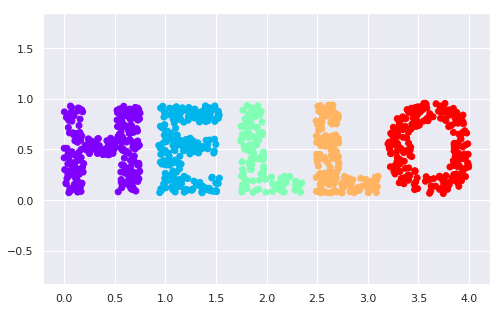

In [3]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:,1], **colorize)
plt.axis('equal')

## 多次元尺度構成法

In [4]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
            [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)

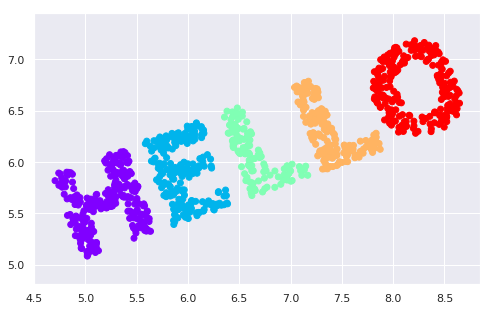

In [5]:
X2 = rotate(X, 20) + 5
plt.figure(figsize=(8, 5))
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

In [7]:
from sklearn.metrics import pairwise_distances

In [8]:
D = pairwise_distances(X)
D.shape

(1000, 1000)

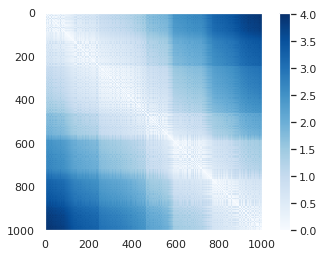

In [9]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar()

In [10]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

In [11]:
from sklearn.manifold import MDS

(-2.0677590819075964,
 2.1283350124574927,
 -1.374706994590171,
 1.3745656559020414)

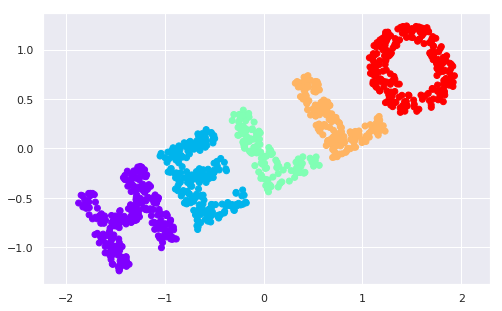

In [14]:
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.figure(figsize=(8, 5))
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal')

## 多様体学習としてのMDS

In [24]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])

In [25]:
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

In [26]:
from mpl_toolkits import mplot3d

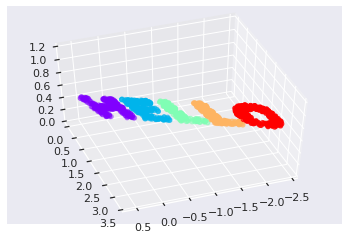

In [27]:
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2], **colorize)
ax.view_init(azim=70, elev=50)

(-2.067759081907622,
 2.128335012458156,
 -1.3747069945903772,
 1.3745656559066646)

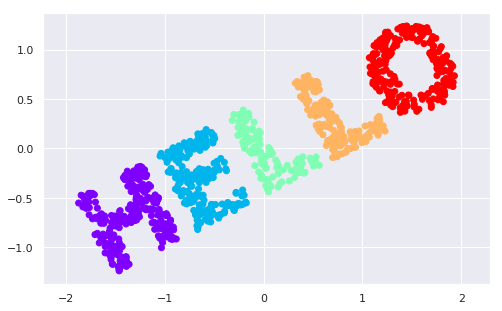

In [28]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.figure(figsize=(8, 5))
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal')

## 非線形埋め込み：MDSがうまくいかない場合

In [31]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

In [32]:
XS = make_hello_s_curve(X)

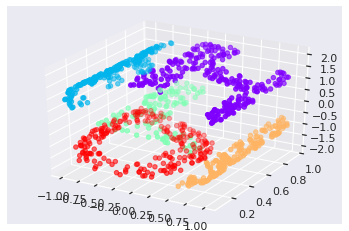

In [33]:
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize)

In [34]:
from sklearn.manifold import MDS

(-2.137743958785896,
 1.9525966315357768,
 -1.9667872566209792,
 1.7978925909661077)

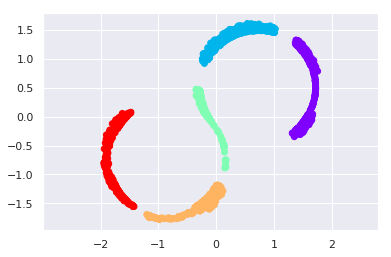

In [35]:
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal')

## 非線形多様体：局所線形埋め込み

In [37]:
from sklearn.manifold import LocallyLinearEmbedding

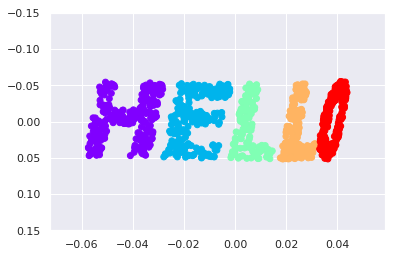

In [38]:
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);